In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()

D:\Anaconda2\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
D:\Anaconda2\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


In [2]:
import mpld3
from mpld3 import plugins
from jinja2 import Template
# mpl.rcParams['figure.figsize'] = 3,3

# 1. Data Wrangling

In [3]:
data = []
for year in range(2010,2014):
    file = "./data/movie_list_%s_v2.json" % year
    with open(file ) as data_file:    
        data += json.load(data_file)
    
df = pd.DataFrame(data)
df.describe()

D:\Anaconda2\lib\site-packages\pandas\core\algorithms.py:348: RuntimeWarning: tp_compare didn't return -1 or -2 for exception
  keys, counts = htable.value_count_object(values, mask)


,detail_url,douban_info,movie_tt_id,name,omdb_info
count,2064,2028,2064,2064,2064
unique,2041,2012,2041,2037,2038
top,http://www.movieinsider.com/m11397/desperate-a...,"{u'rating': {u'max': 10, u'average': 0, u'star...",tt1714866,Starbuck,"{u'Response': u'False', u'Error': u'Incorrect ..."
freq,2,2,2,2,4


In [4]:
# Problem, handling unicode json
df.drop_duplicates('movie_tt_id', inplace=True)
df['temp_string'] = df['douban_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df['temp_string'] = df['omdb_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df = df.dropna()
df.drop('temp_string', 1, inplace=True)
df.drop('detail_url', 1, inplace=True)
df.describe()

,douban_info,movie_tt_id,name,omdb_info
count,2003,2003,2003,2003
unique,2003,2003,1999,2003
top,"{u'rating': {u'max': 10, u'average': 7, u'star...",tt1860152,Frozen,{u'Plot': u'As inventor Andy Brewster is about...
freq,1,1,2,1


In [5]:
df['omdb_info'][0]

{u'Actors': u"Harriet Minto-Day, Jay Laga'aia, Damien Garvey, Sahaj Dumpleton",
 u'Awards': u'4 wins & 5 nominations.',
 u'Country': u'Australia, USA',
 u'Director': u'Michael Spierig, Peter Spierig',
 u'Genre': u'Action, Fantasy, Horror',
 u'Language': u'English',
 u'Metascore': u'57',
 u'Plot': u'In the year 2019, a plague has transformed almost every human into vampires. Faced with a dwindling blood supply, the fractured dominant race plots their survival; meanwhile, a researcher works with a covert band of vamps on a way to save humankind.',
 u'Poster': u'http://ia.media-imdb.com/images/M/MV5BNzg3NDYyMDU4Nl5BMl5BanBnXkFtZTcwODA5NzA5Mg@@._V1_SX300.jpg',
 u'Rated': u'R',
 u'Released': u'8 Jan 2010',
 u'Response': u'True',
 u'Runtime': u'98 min',
 u'Title': u'Daybreakers',
 u'Type': u'movie',
 u'Writer': u'Michael Spierig, Peter Spierig',
 u'Year': u'2009',
 u'imdbID': u'tt0433362',
 u'imdbRating': u'6.5',
 u'imdbVotes': u'98623'}

In [6]:
# Data problems
# 1.['imdb_info']['imdbRating'] do not exist
# 2.['imdb_rating'] is 'N/A', at id 108, 273
# 3.['imdb_rating'] is '23,421', need to get rid of the comma

df['imdb_rating'] = df['omdb_info'].apply(lambda x: x.get('imdbRating', np.nan))
df['metascore'] = df['omdb_info'].apply(lambda x: x.get('Metascore', np.nan))
df = df.dropna()
df = df[(df.imdb_rating != 'N/A') &(df.metascore != 'N/A')]
df['imdb_ratings_count'] = df['omdb_info'].apply(lambda x: int(x['imdbVotes'].replace(',', '')))
df['db_rating'] = df['douban_info'].apply(lambda x: x['rating']['average'])
df['db_ratings_count'] = df['douban_info'].apply(lambda x: x['ratings_count'])
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['imdb_ratings_count'] = df['imdb_ratings_count'].astype(float)
df['name'] = df['name'].apply(lambda x: x.encode('ascii','ignore'))
df['metascore'] = df['metascore'].astype(float)
df['metascore'] = df['metascore']/10
df['genre']=df['omdb_info'].apply(lambda x: x.get('Genre', 'none'))
df['image_url']=df['omdb_info'].apply(lambda x: x.get('Poster', 'none'))
df['douban_url']=df['douban_info'].apply(lambda x: x['alt'])

df.drop('douban_info', 1, inplace=True)
df.drop('omdb_info', 1, inplace=True)

# 2. Movie Overview

In [7]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1662.000000,1662.000000,1.662000e+03,1662.000000,1662.000000
mean,6.386282,5.514019,5.268382e+04,5.901986,18715.155235
std,0.988046,1.703777,1.050602e+05,2.532974,46304.546623
min,1.600000,0.100000,1.200000e+01,0.000000,0.000000
25%,5.800000,4.300000,1.895500e+03,5.800000,131.500000
50%,6.500000,5.550000,9.648000e+03,6.600000,2010.500000
75%,7.100000,6.700000,5.588025e+04,7.500000,12730.750000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


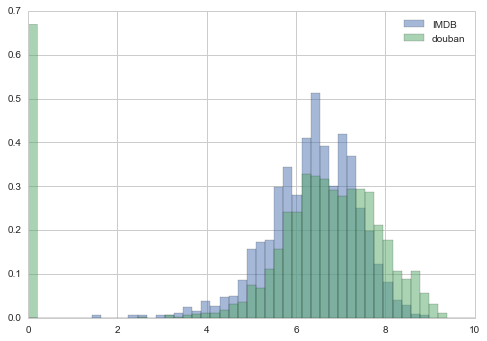

In [8]:
# bins=arange(-0.05,10,0.1)
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins, alpha=0.5,  normed=True, label = 'douban')
plt.legend()

可以发现，有的电影豆瓣电影没有分数。应该把这些去掉

（可以看看这些电影是什么样的）

## 2.1 Empty Score Moives

In [9]:
empty_df = df.query('db_rating == 0')
display(empty_df.describe())
fig=plt.figure()
empty_df['imdb_rating'].hist(bins=arange(-0.05,10,0.1), alpha=0.5)
plt_configure(title='No Douban rating, IMDB Rating Distribution',figsize=(3,2))
fig=plt.figure()
empty_df['imdb_ratings_count'].hist(bins=50)
plt_configure(title='No Douban rating, IMDB Rating Count Distribution', figsize=(3,2))
align_figures()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,227.000000,227.000000,227.000000,227.0,227.000000
mean,6.070925,5.250220,628.911894,0.0,7.048458
std,1.137316,1.645465,1053.300889,0.0,6.173906
min,2.300000,0.900000,12.000000,0.0,0.000000
25%,5.500000,4.150000,168.500000,0.0,2.000000
50%,6.200000,5.400000,391.000000,0.0,5.000000
75%,6.900000,6.500000,726.000000,0.0,12.000000
max,8.400000,8.600000,13492.000000,0.0,23.000000


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAPYAAACZCAYAAAAcsMdHAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAHRJJREFUeJzt3XtcVHX6wPEPyP0maLFbaWi26qqpmVn9BMVcViwvYFZ4
QaV6tZKVEiaZeMk7mpmWKdpWKGt4AwFzzUzynoq3NVpyLU1AFxBmlPswzPn9wc5puMmQzBw8ft//
wJk55zzfc2aeOdfnfG0kSZIQBEFVbJVugCAIzU8ktiCokEhsQVAhkdiCoEIisQVBhURiC4IK3TKx
c3Jy6Nq1K9u3b6/x+meffcbMmTObFOjjjz/mqaeeIjg4mKCgIIYPH054eDiXL19ucqNNzZw5k88/
//y25tEcDhw4wOrVqwHYv38/ixYtskicEydOMHz4cPn/rl278s4779QZLzQ0lD59+sjj9erVi+Dg
YIKDgxk+fDghISEcPHhQHn/mzJkMGDCA4OBgRo4cyTPPPMPChQsxGAx15p2Tk0O3bt3kzzIoKIi/
/vWvTJgwgezs7EaXYc2aNezfvx+A1atXk5yc/LvWRW3mLGd0dDTHjh275Xxmz57Njz/+WO97xulz
cnJ49NFHm9xGa31P7BobwdbWlmXLlvH444/j4+NzW8GeffZZoqOj5eHk5GQmTZrEV199haur623N
W2nnz5/n5s2bADz99NM8/fTTVol77733kpaWRkVFBY6OjgBcvXq1zg/mgw8+SFJSkjycmZnJK6+8
wieffELPnj0BCAsLIywsDACdTkdISAi7d+9m2LBhdeI6OTnVmB/AwoULWblyJStWrLhlm7///nv+
9Kc/AfDmm282bYEb0dhyLly4sNF5HDlyhJCQkHrfM06fk5ODjY1Nk9tnre9Jo4nt6OhIWFgYERER
bN26FTu7mpMUFxfz3nvvkZmZiY2NDX5+fkRGRmJr2/he/siRI0lJSWHXrl28+OKLpKens3z5csrL
y7G3t2fq1Kn4+fmRlJTE119/zbp16wDqDKenp7Nnzx5KSkr4v//7P9555x1sbW3Zvn07W7duRa/X
o9VqefXVVwkJCSEpKYlvvvkGW1tbfv31V+zt7Vm2bBkPP/xwjfYlJSWxfft2ysrKcHd3Z926dcyb
N49ff/0VrVaLq6srK1as4ObNmyQkJGAwGHBzc8PHx0duX2hoKI8++iinT5/m6tWr9O3bl2XLlgGQ
mJjIhg0bcHZ25oknnmDjxo1kZGSY98n9j6enJw8++CD79u3j2WefBWDnzp0MHz6chISEBqfr2rUr
oaGhxMXF1ZuIJSUl6HQ67rnnHrPaUV5eTl5eHvfeey8Aly9fZv78+ZSWlpKXl8ef//xnVq5cybZt
2/jhhx9YtmwZtra2fPvtt3Tu3JmwsDB69uzJq6++ypEjR8jPzyc0NJSJEydiMBiIiYkhLS0Nd3d3
evbsycWLF9m0aVOj7aq9nKGhoYSGhjJ48GDmz5/PmTNnsLe3p3379ixevJjY2Fjy8vKYPn06MTEx
LF++HE9PTy5dusSYMWPYs2cPoaGhdO/eHYPBQHR0NBkZGdjb2xMdHU3Pnj35+OOP0Wq18kbMODxi
xIgGvye5ubnMnTuXnJwcAIKCgnj55ZfJyclh0qRJDBw4kHPnznHz5k2mTZvG0KFDb7ncjWafjY0N
4eHhuLi41PsFWLBgAV5eXqSmprJjxw4yMzP5+9//3ugKN+rSpQsXLlxAq9UydepUoqOjSU5OZunS
pbz99tvygt5Kbm4uGzduZOfOnWRmZrJ161ZKS0vZvn07GzZsIDExkZUrV8oJBdU/BnPmzCE1NZU+
ffo02OaLFy8SHx9PXFwcBw8exMPDg4SEBPbs2UOPHj2Ij4+nZ8+ehISE8MwzzzBt2rQ688jKyiI+
Pp7U1FS+//57Tpw4wc8//8yKFSuIi4sjMTERV1fXend7zREUFMTOnTvl4X/+85/y7vqtdO3alQsX
LsjDn3/+ubwLO2jQILy9vXnsscfqnba8vJzg4GBGjBhB//79GTVqFA899BDTp08HYOvWrQQHB5OQ
kMDevXvJysriwIEDjBs3jh49ehAVFcVf/vKXGvPU6XS0adOGL7/8klWrVrFixQp0Oh1bt27lxx9/
5KuvvmLLli1cuXKlSVvL2ssJcObMGU6ePElKSgo7duygffv2XLhwgYiICLy9vVmxYoW8J9O6dWt2
7drFuHHj6qwDX19fkpKSePPNN5k6dSp6vb7BdtzqezJ9+nSeeuopUlNT+fLLL0lJSWH37t1A9ffH
z8+Pbdu2ERkZyfLlyxtdZrNPni1fvpykpCSOHj1a4/VDhw4xfvx4AOzt7RkzZkyNY5rG2NjY4OTk
xLlz5/Dx8eGRRx4B4OGHH+axxx7jxIkTjc5j5MiRODo6Ymdnx4gRIzh69CguLi6sW7eOtLQ0Vq1a
xdq1aykrK5On6d69O97e3gB069YNrVZb77y7dOmCi4sLAEOGDCE4OJj4+HgWLVrEiRMnKC0tbbR9
gwYNAsDV1RUfHx9u3LjBoUOH8PX1ldsQGhra6Hwa4u/vT0ZGBoWFhZw+fZqHHnoIDw8Ps6Z1cnKS
/w8LCyMpKYnU1FSOHz9O69atWbBgQYPTJSUlkZKSQkxMDFqtFl9fX5ydnQF4++238fLy4tNPP2Xe
vHnk5+dTUlIiT9/QncyDBw8Gqj+fyspKysrKOHjwIEFBQdjb22NnZ9fgbrK5ywnVn2urVq14/vnn
WbVqFQEBAfTu3bve9vXt27feebZu3ZrAwEAAfH19Afjll1+a3LaysjJOnz7N2LFjAXBzcyM4OJhD
hw4B1Xk1cOBAoPq7euPGjUbnaXZi33fffcybN4+oqCg0Go38eu2tjMFguOWvVm3nz5+nc+fOSJJU
58OuqqpCr9fX+XWurKysuRAmu/2SJGFnZ0dubi5BQUFcu3aNvn371vmFNB6PQvWPS0NfNGNSA2ze
vJlZs2bh7OzM8OHDefbZZxuczlTtL5WxjabrzpxDl4bY29szZMgQdu3axc6dOxk1apRZ0xnXfX0c
HR0JCgri1KlTjc7H19eXSZMmERERQXFxMYB86PbAAw8QFhZGt27dzGqT6ecCv60r0/Xc1HVV33K6
u7uTnJxMVFQUrVq1IiIigri4uHqnN/0OmKrdDoPBIB+qmra39ve1tvr21CRJkqezt7eXX7/Vd7VG
2xobwXQmgYGBDBgwoMYK8PPz4x//+AdQvSu1ZcsW+vfv32hggG3btpGdnc3QoUPp1asXly9f5vz5
8wD85z//4dSpU/Tr1w8vLy8uXLiATqdDr9fLZ1SNdu/ejU6no6KigqSkJAYMGMD58+dp06YN4eHh
9O/fn7S0tDrL01RHjhxh1KhRPPfcc3To0IG0tDT5Q2nVqlWjH6ApX19fjh07Rl5enrwubsfIkSNJ
SkoiPT0dPz8/4NbL+q9//YuEhAQmTpxY7/sGg4Fvv/1W3h2trfa8X3rpJTw8PPjoo4+A6nU1ZcoU
hg4diiRJnDt3jqqqKgDs7OzM+vE3xhg4cCApKSny55+UlGT2rnhDy/ndd98xceJEHn30UV5//XWC
goLIzMxsUvs0Gg0HDhwAqs9wOzk50aFDB9q0aSOfKyktLeXw4cPyNPV9T1xdXenVq5ecR0VFRezc
uVPeC6i9rs35Djd68qz2CoyOjub06dPy67NmzWLBggUMHz6cyspKBgwYwOTJk+vM57///S9JSUny
FkCSJBwdHfH09MTBwQEHBwdWrVrFggULKCsro1WrVixZsgQfHx/atWtHv379CAwMxNvbmyeeeIKf
fvpJnne7du0YO3YsZWVlBAQEEBQURHl5OYmJiQwZMgRXV1ceeeQR2rRpw6+//troSmnISy+9xJw5
c0hMTMTW1pb

In [10]:
# these 2 table can be combined with an interactive table sorting
# empty_df.sort_values(by='imdb_rating',ascending=False).head()

In [11]:
empty_df.sort_values(by='imdb_ratings_count',ascending=False).head()

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,genre,image_url,douban_url
1318,tt1520498,The Oogieloves in the Big Balloon Adventure,7.2,3.2,13492.0,0.0,0,"Adventure, Family",http://ia.media-imdb.com/images/M/MV5BMTk0ODM0...,http://movie.douban.com/subject/4067243/
208,tt1396557,Winnebago Man,7.2,7.1,3564.0,0.0,12,"Documentary, Biography, Comedy",http://ia.media-imdb.com/images/M/MV5BMjEzNzg5...,http://movie.douban.com/subject/3794525/
1945,tt1662293,Nothing Left to Fear,4.4,1.2,3388.0,0.0,17,Horror,http://ia.media-imdb.com/images/M/MV5BMTU3NjE5...,http://movie.douban.com/subject/10546739/
1442,tt2112293,The Comedy,6.4,4.6,3049.0,0.0,11,Drama,http://ia.media-imdb.com/images/M/MV5BMjA0OTA3...,http://movie.douban.com/subject/7015721/
1369,tt1606829,The Other Dream Team,8.4,6.9,2927.0,0.0,23,"Documentary, Sport",http://ia.media-imdb.com/images/M/MV5BODg5MzQ3...,http://movie.douban.com/subject/5155675/


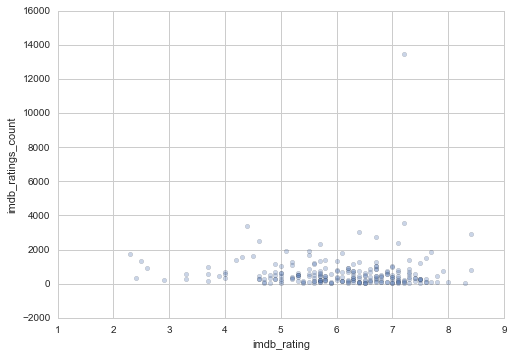

In [12]:
empty_df.plot(kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)

## 2.2 Delete Empty movies, Go ahead

In [13]:
df = df.query('db_rating > 0')

# 3. Movie Overview (两种评分都有的)

## 3.1 Overall Info

In [14]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1435.000000,1435.000000,1.435000e+03,1435.000000,1435.000000
mean,6.436167,5.555749,6.091829e+04,6.835610,21674.556098
std,0.953249,1.709649,1.108509e+05,1.022375,49186.918616
min,1.600000,0.100000,2.050000e+02,2.600000,20.000000
25%,5.900000,4.300000,3.924500e+03,6.200000,467.500000
50%,6.500000,5.600000,1.579300e+04,6.800000,3510.000000
75%,7.100000,6.800000,7.032400e+04,7.600000,16806.500000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


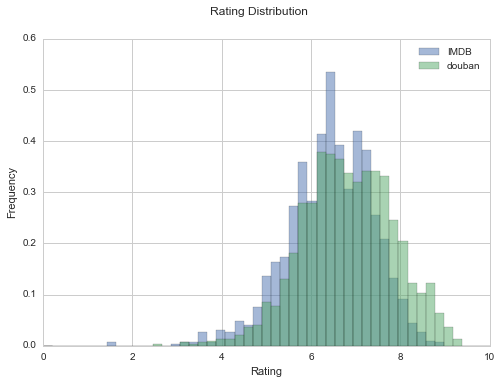

In [15]:
# 1. Why douban is higher?
# 2. Why the std is close to 1? (but IMDB < Douban, indicating a narrower distribution)
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

1. 两者大致分布正态分布，可以认为样本量基本足够
2. 这不是标准的正态分布，有偏度。原因？
3. 豆瓣电影偏高（相对有移动了）

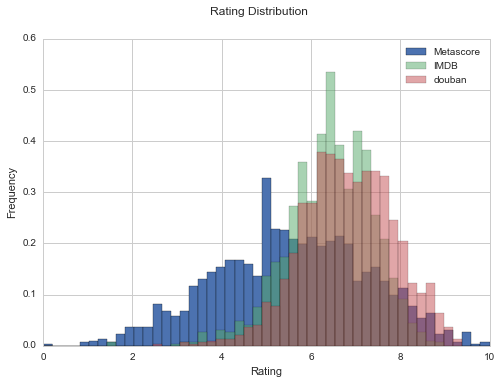

In [16]:
df['metascore'].hist(bins=bins, normed=True, label = 'Metascore')
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

并不是所有的影评分布都会类似. 比如Metascore的分布，就大为不同

Metascore的分数经过了人工的调整、加权，所以分布差别很大

## 3.2 Good Movies

Any your favorite?

### 3.2.1 Order by IMDB Rating

In [17]:
# Good Movies
# display(df.sort_values(by='imdb_rating',ascending=False).head(5))
movie_list(df.sort_values(by='imdb_rating',ascending=False))

### 3.2.2 Order by Douban Rating

In [18]:
movie_list(df.sort_values(by='db_rating',ascending=False))

## 3.3 Scatter Comparison

scatter,可以非常直观的比较两者的差别

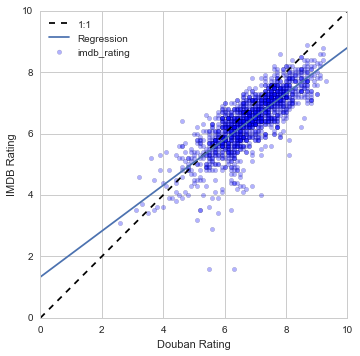

In [19]:
fig, _ , scatter_plot = plot_movie_scatter_comparison(df, title='')

In [20]:
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare_all.html')

D:\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:171: UserWarning: Legend element <matplotlib.collections.PathCollection object at 0x00000000126970B8> not impemented
  warnings.warn("Legend element %s not impemented" % child)


对比回归线，可以看到
1. 并不是1:1的关系，斜率不同（原因？可能是打分制？），而且分数越高，差别越大

    - IMDB: 10星制。没有人会打10星  
    - 豆瓣：5星制。4星以上都会打5星
    
    豆瓣的打分制概念简单，不需要太精确，体验更好。

2. IMDB比豆瓣要齐整得多。豆瓣确实有一些电影，偏离回归线较大[(4,6)附近]

3. Play with the scatter, 发现“打分人数”的问题

## 3.4 Rating Number Problem

In [21]:
for min_ratings_number in [0, 1000,3000,5000,10000, 20000,40000]:
    min_ratings_number = min_ratings_number
    temp_df = df.query("(db_ratings_count > @min_ratings_number) & \
                   (imdb_ratings_count > @min_ratings_number)")
    title = 'Min Rating: ' + str(min_ratings_number)
    fig, fit_params, _ = plot_movie_scatter_comparison(temp_df, title=title)
    fig.set_size_inches(2.5,2.5)
    fig.show()
    print min_ratings_number, fit_params[1], len(temp_df)
align_figures()

D:\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0 0.746613559846 1435
1000 0.761961689062 954
3000 0.779117292801 735
5000 0.794122490774 609
10000 0.809228311458 436
20000 0.785245079648 303
40000 0.782214462177 190


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMAAAADHCAYAAABP2Vy/AAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsnXlgVNX5v5/ZM5mZJJOd7CEJ2UiURRAFlIggilTEVlCk
trW1P6tVtIq1tti4oKjYr1QLShXFBVtFEQSpiMgiEAghhC1hCYQkZM8kmclsd+b+/rhkIEBIAklI
YJ5/kjt3OefOnM+973nPe94jE0VRxIuXKxT5pa6AFy+XEq8AvFzReAXg5YrGKwAvVzReAXi5ovEK
wMsVjVcAHaCsrIyUlBTuu+++s/b9+c9/JiUlBZPJxJ49e3j00Uc7de0vv/ySoUOHMnnyZO644w5+
9rOfMXbsWJ5++mkcDke75//mN7/BZDIB8OCDD3L48OFOld9R1q9fz6RJk5gwYQKPPfYYFoulW8rp
cUQv7VJaWipmZmaK119/vVheXu75vLm5WRw3bpyYkpIi1tfXX9C1ly1bJj744IOtPrPb7eKdd94p
fvbZZ+2en5ycfMFld5Ta2lpxxIgRYklJiSiKovjqq6+Kzz33XLeW2VN43wAdRC6Xc+utt/L11197
Pvvf//5HVlaWZzsnJ4fbb78dkN4ML7zwAjNmzGDcuHH8/ve/x2q1dqis+vp6zGYz/v7+APzwww9M
nTqVu+66i6ysLN58801PGQAzZsygoqKCrKws9u7dS05ODtOmTeOpp55i8uTJTJw4kZycHADq6ur4
/e9/z2233ca9997LH//4R/75z38C8OabbzJ//vyz6rN582YyMzOJjo4GYNq0aaxYsaJT31+v5VIr
sC9QWloqDho0SNy7d6946623ej6///77xYMHD3reANu2bRMnTpwoiqIoPv300+K0adNEp9MpOp1O
cfLkyeKyZcvOuvayZcvEIUOGiHfccYc4YcIE8dprrxWnTp0q/uc///EcM2PGDPHYsWOiKIpiZWWl
mJaW5nnqJycniyaTSRRFURwzZoy4Z88ecdu2bWJ6erp44MABURRF8b333hOnT58uiqIozpw5U3zt
tddEURTFqqoqceTIkeL8+fPPe/8LFy4UZ8+e7dkWBEFMSUkRzWZzp77H3ojyUguwL5GWloZcLmff
vn0EBgbS3NxMYmIiYhvRJKNGjUKplL7iAQMG0NDQcM7jhg4dyoIFCwB4++23WbFiRas3y7/+9S/W
r1/P119/zZEjRwCwWq0EBAQAnLP8iIgIkpOTPfX+8ssvAdiwYYPn/5CQEMaPH9/ufbd1fwqFot1z
ezteE6iTTJo0ieXLl7N8+XImTZp03mN9fHw8/8tksjYb0uk89NBDREZG8swzzwBSQ588eTL79u1j
4MCBPPXUUygUilbXkslkZ11Ho9Gcs+wzG21HGnG/fv2oqqrybFdUVODn59fq/voqXgF0kJYGNGnS
JL799ltWr17tsfe7mtmzZ7N161a+//57jh07hsVi4bHHHuPGG29k27ZtOJ1OXC4XAEqlEqfT2eFr
jxkzhs8//xyQ+hrffffdOQV0OiNHjmT37t2UlJQA8Nlnn3HTTTdd4N31LrwmUAdpaSRhYWEkJiZi
MBjw8/Nrta+riI6O5oEHHuDll19m5cqV3HDDDdxyyy34+fkRGxtLYmIiJSUlREdHM3bsWO655x7e
euutDtXj6aef5tlnn2XSpEkEBAQQGRmJVqsFpE6wTCbjkUceaXVOYGAgL730Eo888giCIBAdHc3c
uXO79J4vFTKxI+9lL5cNn3zyCenp6Vx11VU4HA6PJ2jUqFGXumqXBO8b4AojMTGR7Oxs3G43giBw
yy23XLGNH3rgDZCfn89rr73GkiVLKCkp4emnn0Yul5OUlMTs2bO7s2gvXtqlWzvBixYt4tlnn/V0
0ubMmcPjjz/ORx99hNvtZu3atd1ZvBcv7dKtAoiNjeWtt97ybO/du5ehQ4cCMHr0aLZs2dKdxXvx
0i7dKoCbb765lZ/5dGtLp9PR1NTUncV78dIuPdoJlstP6c1isXjciOcjNze3O6vk5TJkyJAhHT62
RwWQlpbG9u3bueaaa9iwYQPXXntth87rzA1dLLm5ud7y+lh52dnZzJ49m7i4OM8gX0fpUQHMmjWL
v/71rzidThISErjlllt6sngvlyEtjT8+Pp4ffviBmpqaTp3f7QKIjIxk6dKlAMTFxbFkyZLuLtLL
FUJxcTFz5szxNP7Y2NjeJwAvXrqL+Ph4Vq9eTXx8PLGxsRd0Da8AvPRpbrzxxos63xsN6uWKxisA
L32GwsLCLr+mVwBe+gTZ2dkMHDiQVatWdel1vQLw0utpcXVGRUWRnp7epdf2CuAiyc/PP2e+IJCm
M06bNo3i4uIertXlw+mDXOvXr79gb09beL1AF8GiRYtYvnw5Op3urH179uxh9uzZVFZWXoKaXR68
/PLL3dr44TIRQFxc3Dk/P3r0aJcc3xYt0a5PPfUUACtXrsRqtfLzn/8cp9PJ22+/zZNPPtmpa3o5
xYgRIxg4cCArV67slsYPl4kALhU333wzZWVlnu2JEyd6/h80aBDQdkoRL+1zww03sGvXrm5Nv3JZ
CKCzT+7OHu+l+3A4nGzbVoXZrESvFxg+PBS1WuXZ3925hy4LAVxqvE/5C2fbtipMpkgATCbYtq2M
UaOk7fbE0RV4vUBdQEs6kpUrV/Lf//73nPu8nBuzWXoGf/bZC2za9B/PNpwShyCEYTJFsm1bVVuX
ocFs57WPOj93xPsGuEhOj3Y9vQ/QwocfftjTVepT6PUCCxZk88kns+nXL5Hx4//n2Xe6GM613cLe
I7XMXbKDukYbY1KjOlW+VwBeuoxzmSztsXbtO3zySTZhYdH83/99xMiRUZ7r5OfXUFxcTkhICHq9
jGHDWmfAc7tFPl93kI+/3Q8yGTNuTQU6N83WKwAvXca57Hlf37OPM5ubWby4kGXL3uOHH/5JbGws
P/74o8fVuXFj2UnTR4nNpqWsrIzk5FDglABMTXbmfZJLXlE1Qf4+PDl9KOn9gzo9hdYrAC9dxrlM
lnMJYPHiQg4eDGHz5g/w94/j17/+Zys/f8t1BEFNTIwfCoWV9PQg7HYBgIJDNbz28Q7qGu0MTQ3j
samD8Ndrzi6oA3gF4KXL0OsFTq7W5NmGs02j6moVvr7h3HTTf5HJwtiypYo5c/IAEa3Whc2mBgRA
pKREgVxeh4+PkqHXNLP0u0I+XXMAZDJ+NTGNO25IRC6/cEeDVwBeuozhw0PZtq2sVR+goKDiLNOo
oaGI+vp+GAzjqaw0U1lpxen0Qal0YzT6o9XWcOJEFfX1RwgK8iMjIxGHu4ll245wvNZMcICWp6YP
JTU+8KLr7BWAl4um9RMebropEIfDydtv5/HDD+XYbLVERVXTr18Iej2MGBHFunUFlJcHUl5ejc0W
yaFDTYiiCkHIJzBwACqVP3a7gYCAJlwaM3uayrA67AxLC+exaYMw+Kq7pO49LgBBEJg1axZlZWUo
lUqef/554uPje7oaF01OTg6PPfYYiYmJAJjNZmJiYnjttdc8q8L0NH/84x8964f1JOfq/ObnV5GX
F4nVmkBNTQklJWaGDetPTIwf1dV5ZGT4ExqaSV3dQRoblYCUot1u90MUGwgISEIQzLgCXBxoKkEm
lzFmYBQz7x/cpWMrPf5L/fjjj7jdbpYuXcpPP/3EG2+8cUl+tK5gxIgRvP76657tJ554gnXr1jFu
3LhLUp9L9T2aTJCfX8nhw1ZARlxcNVu3lnPsmJWmpnqs1hXU1r6DQvEaong7JSVV7Nlj5sSJI1gs
DtxuGW53JKBAobChVOrQ6MqJueo4Kn8Tcrece0YNYPKE/l0+sNjjAoiLi8PlciGKIk1NTahUFze0
/d6KvWzOL2v

对比上面这几张图，可以发现随着评分人数的增加，偏离逐渐收窄，但并不迅速收窄

一直到4W人以上，豆瓣和IMDB才算均衡。也就是说，
- 部分电影的偏离，确实是由于看的人很少，打分不客观引起（打分样本过少）
- 部分偏离的电影，是有相当一部分人观看的 （>3K），这个现象确实存在

### 3.4.1 Ratings Number Distribution (Optional)

In [22]:
# # This plot is not very informative, what can I do?
# # Why is this kind distribution? -> Poisson
# fig=plt.figure()
# df['imdb_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
# plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
# fig=plt.figure()
# df['db_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
# plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
# align_figures()

In [23]:
# fig=plt.figure()
# df['imdb_ratings_count'].hist(bins=linspace(0,100000), alpha=0.5, figsize=(4,3))
# plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
# fig=plt.figure()
# df['db_ratings_count'].hist(bins=linspace(0,50000), alpha=0.5, figsize=(4,3))
# plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
# align_figures()

### 3.4.2 Correlation between Rating and Rating Numbers (Optional)

In [24]:
# df.plot(kind='scatter', x='db_ratings_count', y='imdb_ratings_count', alpha=0.30)
# plt_configure(title='Douban ratings count vs. IMDB ratings count')

In [25]:
# fig, ax = plt.subplots()
# df.plot(ax=ax, kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)
# plt_configure(title='IMDB rating vs. ratings count', figsize=(4,3))
# fig, ax = plt.subplots()
# df.plot(ax=ax, kind='scatter', x='db_rating', y='db_ratings_count', alpha=0.30)
# plt_configure(title='Douban rating vs. ratings count', figsize=(4,3))
# align_figures()

# 4. Comparison among Popular Movies

重新选择评分人数更多的电影，更有说服力

## 4.1 Overviews

In [26]:
min_ratings_number = 2000
df = df.query("(db_ratings_count > @min_ratings_number) & \
               (imdb_ratings_count > @min_ratings_number)")

df['diff']=df['db_rating']-df['imdb_rating']
df['imdb_rank'] = df['imdb_rating'].rank()/len(df)*100
df['db_rank'] = df['db_rating'].rank()/len(df)*100
df['rank_diff']=df['db_rank']-df['imdb_rank']
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
count,822.000000,822.000000,8.220000e+02,822.000000,822.000000,822.000000,822.000000,822.000000,8.220000e+02
mean,6.636375,5.656204,1.019389e+05,7.013869,37004.064477,0.377494,50.060827,50.060827,2.182628e-15
std,0.878254,1.682859,1.321592e+05,0.914960,60361.058882,0.553247,28.863203,28.867706,1.687155e+01
min,3.400000,1.100000,2.080000e+03,4.100000,2006.000000,-1.800000,0.121655,0.182482,-4.993917e+01
25%,6.100000,4.500000,2.290700e+04,6.400000,5215.250000,0.000000,24.209246,27.068127,-9.549878e+00
50%,6.650000,5.700000,5.627600e+04,7.000000,12622.500000,0.400000,50.152068,49.756691,-3.649635e-01
75%,7.200000,6.800000,1.286085e+05,7.600000,40348.750000,0.700000,73.236010,73.236010,9.732360e+00
max,8.900000,10.000000,1.255291e+06,9.200000,586362.000000,2.700000,100.000000,99.878345,6.180049e+01


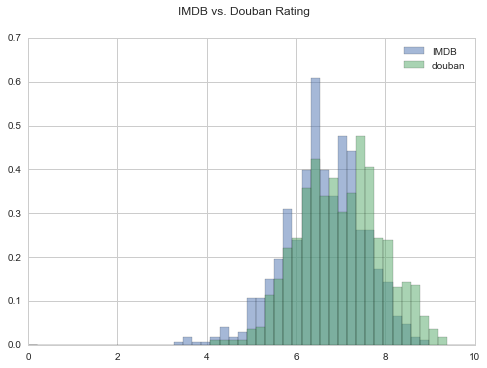

In [27]:
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5, normed=True, label = 'douban')
plt_configure(title='IMDB vs. Douban Rating', legend=True)

### 4.1.1 Best Movies

In [28]:
# df.sort_values(by='imdb_rating',ascending=False).head()
movie_list(df.sort_values(by='imdb_rating',ascending=False)[:20])

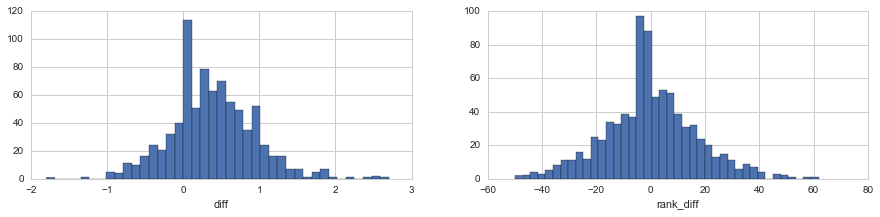

In [29]:
plt.subplot(1,2,1)
df['diff'].hist(bins=40,figsize=(15, 3))
plt.xlabel('diff')
plt.subplot(1,2,2)
df['rank_diff'].hist(bins=40)
plt.xlabel('rank_diff')

## 4.2 Scatter Comparison

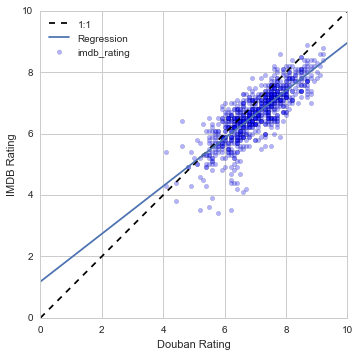

In [30]:
fig, _ , scatter_plot = plot_movie_scatter_comparison(df, title='')

In [31]:
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare.html')

D:\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:171: UserWarning: Legend element <matplotlib.collections.PathCollection object at 0x00000000130C2400> not impemented
  warnings.warn("Legend element %s not impemented" % child)


1. 对比前后scatter plot, 总体趋势是不变的
2. Play with the Scatter Plot， 看看有哪些电影差别很大:

    1. 回归线以上，IMDB >> 豆瓣；回归线以下，豆瓣 >> IMDB
    2. 总体而言，豆瓣评分确实更分散，(7,4.5)附近的一个cluster, 可以算作典型的偏离
    3. 这些偏离的电影，有何规律？

## 4.3 Absolute Difference

先查看绝对分值差别大的电影， 再看相对差别大的电影（类似于回归线）

### 4.3.1 豆瓣 >> IMDB

In [32]:
# df.sort_values(by='diff',ascending=False).head()
movie_list(df.sort_values(by='diff',ascending=False))

### 4.3.2 IMDB >> 豆瓣

In [33]:
# df.sort_values(by='diff',ascending=False).head()
movie_list(df.sort_values(by='diff',ascending=True))

## 4.4 Rank Difference

### 4.4.1 Douban >> IMDB

In [34]:
# df.sort_values(by='rank_diff',ascending=False).head()
movie_list(df.sort_values(by='rank_diff',ascending=False))

### 4.4.1 IMDB >> 豆瓣

In [35]:
movie_list(df.sort_values(by='rank_diff',ascending=True))

我观察到的规律: 似乎很多动画的评分，差别很大，例如：
1. 蓝精灵
2. Rio
3. 冰川时代
4. 疯狂原始人

那么，是不是存在某类电影，评分差别会很大？

接下来，按类别分析

# 5. Genre Comparison

In [36]:
def category_overview(df, category):   
    sub_df = df[df['genre'].str.contains(category)]
    fig, _ , scatter_plot = plot_movie_scatter_comparison(sub_df)
    print len(sub_df)

In [37]:
for category in ["Romance", "Drama", "Action", 'Sci-Fi', 'Animation', 'Mystery', 'Crime', 'Adventure', 'Documentary', 'Comedy']:
    category_overview(df, category)
    plt_configure(title=category)
    plt.gcf().set_size_inches(2.5,2.5)
align_figures()

143
420
212
61
51
67
127
150
24
283


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMAAAADHCAYAAABP2Vy/AAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnXlAVOX6xz+zMcCwDIuCCAKiLIoLUpomLrgvmWa33Nvu
/d0y09witzD37Vo39zK1tKLNPdMuKYmmokjuWyoioCAIyDLALOf3BzGBiqzDej5/cWbOeZ/nDO/3
nHd53ueVCIIgICLSQJHWtAMiIjWJKACRBo0oAJEGjSgAkQaNKACRBo0oAJEGjbymHahP+Pr64u3t
jVQqRSKRoNFosLa2JjQ0FH9//5p2T+QxSMR5gKrDz8+P48ePY2tra/xs06ZN/PLLL4SFhdWgZyIl
Ib4BqhBBECj6PNHr9SQmJqJWqwHQ6XQsWbKEY8eOIZPJaNeuHTNmzMDS0pLg4GCee+45IiIiyMjI
YMKECZw+fZoLFy6gUChYt24djRo14tChQ2zYsAGdTsf9+/d5/vnnmTRpElFRUXz00Ue4ublx7do1
tFotH3zwAR07diQnJ4f58+dz+vRpFAoFvXr1YvLkyWi1WlasWMHJkycxGAz4+fkxe/ZsVCpVTf2E
1Y8gUmX4+PgIzz33nDBkyBCha9euQq9evYQFCxYIqampgiAIwn//+1/hnXfeEfR6vSAIgjBjxgwh
NDRUEARB6Nmzp7BkyRJBEAThp59+Evz8/IQrV64IgiAIb7/9trBhwwZBEARh3Lhxwq1btwRBEISk
pCShVatWQlpamnDixAmhdevWwuXLlwVBEIRNmzYJY8aMEQRBEBYtWiRMmTJFEARByM/PF8aMGSNE
RUUJq1evFpYtW2b0f+XKlcLcuXNN+RPVOsQ3QBWzdetWbG1tuXTpEv/6178ICAjA3t4egMjISKZM
mYJUWjD2MHbsWN5++23jtX379gWgWbNmNGrUCG9vbwDc3NxIT08HYN26dURERLB7925u3LgBgEaj
AcDFxQUfHx8AWrVqxY4dOwA4duwYM2bMAEChULB161YAli1bRmZmJkePHgUK3lAODg4m+mVqJ6IA
qhjhryaQn58fM2bMYNasWbRv3x4XFxcMBkOxc/V6PTqdznhsZmZm/Fsuf/Rfo9FoGDp0KH379uWp
p57ixRdfJDw83GhTqVQaz5VIJMbP5XI5EonE+N3du3cxNzdHr9cza9YsgoKCjOXn5eVV9ieoU4jD
oCZk0KBBdOjQgYULFwLQtWtXvvnmG3Q6HQaDga+//ppnn322zOXdunWLnJwc3n33XXr06MGJEyfQ
arXo9fonXte5c2d27tyJIAjk5+czceJETp06RVBQENu2bUOr1WIwGJg1axYrV66s1D3XNUQBVCFF
n7KFzJ49m8jISI4ePcrbb7+No6MjQ4cOZdCgQcYncEnXPoyvry/du3enf//+vPDCC0RERNCiRQvi
4uKeeN2ECROQy+UMGTKEF154gR49etC7d2/Gjx+Pq6srw4YNY/DgwUgkEkJCQip283UUcRhUpEEj
vgFEGjQmF8CZM2cYO3YsAHFxcYwaNYoxY8bw4Ycfmtq0iEipmFQAGzduZPbs2Wi1WgAWL17MlClT
2LZtGwaDgfDwcFOaFxEpFZMKwN3dnTVr1hiPL1y4wFNPPQVAt27dOHbsmCnNi4iUikkF0KdPH2Qy
mfG4aH9bpVKRmZlpSvMiIqVSrRNhhTOgANnZ2djY2JR6TXR0tCldEqmHBAYGlvncahVAq1atOHny
JE8//TSHDx/mmWeeKdN15bmhyhIdHS3aq2P25s2bR2hoKB4eHvzwww/lurZaBRASEsKcOXPQarV4
eXnRv3//6jQvUg8prPyenp4cOnSIlJSUcl1vcgE0bdrUGAvv4eFhDMQSEaksN2/eZPHixcbK7+7u
XvsEICJiKjw9Pfn555/x9PTE3d29QmWIAhCp0/To0aNS14uhECINGlEAInWGK1euVHmZogBE6gTz
5s3D39+fffv2VWm5ogBEaj2FQ52urq60bt26SssWBVBJika7PoxGo2HkyJHcvHmzmr2qPxSd5IqI
iKjwaE9JiKNAlWDjxo3s2rXrsWlEzp8/T2hoKElJSTXgWf1gyZIlJq38UE8E4OHh8djPY2Njq+T8
kiiMdn3vvfcA2Lt3LxqNhn/84x9otVrWrl3L9OnTy1WmyN907twZf39/9u7dW6bKX5HFjfVCADVF
nz59SEhIMB4PHjzY+HdAQABQsX+KSAHdu3fnjz/+KBZRXBJ3UrJZ8sVJxvWwLpeNeiGA8j65y3u+
SM1Rlsp/7s8UFn8RRWaOFmiAAqhpxKd8zXHgeCzrfjwLwDsvtQfKFwskjgJVAYUpTfbu3cv333//
2O9EnsyCBQv47rvvyny+Xm/gs53nWP39GSzNFcx/swt9O5W/kyy+ASpJ0WjXon2AQr788svqdqnO
UTjU2aJFC4YOHVosQ97jyNZoWbb1FKevJOPmZM0Hb3TC2aFiCX1FAYjUKEXH+cPDw0ut/HdSspm/
6Ti3k7J4ys+J6WMCsTRXVNi+KACRGqO8k1xFO7vPd/PitedaI5NWrokpCkCkRoiPj2fFihVlrvyF
nV2JBCa+1J4+FWjvPw5RACI1gqurK7/88gtNmjR5YuXX6w1s2nOB3ZE3sLY0Y+arT+Pv5VhlfogC
EKkxSkuKkK3RsmzbKU5fTqaZszVzXq94Z7ckRAGI1EoSU7KY//kJ4pOrprNbEtUuAJ1OR0hICAkJ
CcjlcubPn4+np2d1u1FpoqKiePfdd2nRogUAWVlZNGvWjBUrVjx2c4vqYOLEiXzyySc1Yrs0zp07
R5s2bcp07tk/77Hki5Nk5mgZ2t2LVwdXvrNbEtU+Efbbb79hMBgICwtj/PjxfPTRR9XtQpXRuXNn
vvzyS7788ku2b9+OTCbj4MGDNeZPban8+flaIiMT+PnnJGJi0gkNDaVdu3Zlytnz87FYPthwDE2e
jokvteeNIf4mq/xQA28ADw8P9Ho9giCQmZmJQlG519qmPRc4eiah9BPLSF5+PsGJF3j9udIXXhQN
gcjPzyclJQUbGxtWrlzJqVOnMBgMvPbaa/Tr14+zZ88yb948rKyssLe3R6lUMmHCBEJCQnBxcaF7
9+4EBQWxYMECANRqNYsWLSI/P5/Jkycbd3eZO3cuzZs3Z9KkSWRlZZGbm8vkyZPp0qULXbt25ciR
I1y8eJEFCxYgk8lQKpUsWLAAvV7P1KlTUSqVZGZm0rZtW+bOnVtlv1tRTpxIJj29KQA//LCIAwc+
wd3dA0FwY8+eBK5fT0SjkSOXy2nb1hyFQoFGY87J2JtE30g2SWe3JKpdACqVivj4ePr37096ejob
NmyobheqjOPHjzNu3DhSU1ORSqW8/PLL5OfnEx8fz9dff01+fj4vvfQSXbp0Ye7cuSxfvhwvLy8+
+ugjkpOTAcjIyODAgQPIZDJefvllFi1ahJeXFz/88AOfffYZHTp0wM7OjmXLlnHt2jU0Gg1xcXGk
p6ezceNGUlNTHwnumzNnDosWLcLHx4dff/2VRYsWERISQmxsLCtXruSZZ56hd+/epKammmRTvKys
gmoVFjaPAwc+wcnJjeXLwzA378SFC6lcuuQDZNKsWVO2b4/Bzd2FBMMN4tOScbA2Z8k7Xau8s1sS
1S6ALVu2EBQUxOTJk0lKSmLcuHHs2bPniTOAT8oP2s4F2rlU9T8xt9ScpFevXsXHx4cJEyaQlZXF
4sWL0Wg0HDx4kOjoaIYNGwYU9A3+97//kZCQQHp6OtHR0cZdJM+dO0fjxo35448/jGVOmzYNKNhA
z9nZmW7duuHo6MioUaOQy+UMGzaMFi1a0LFjR9544w30ej39+vVDpVKh1WqJjo4mISGBrKwsoqOj
USgUnD9/nnP

可以发现，动画和其他类别，显著不同。具体画如下

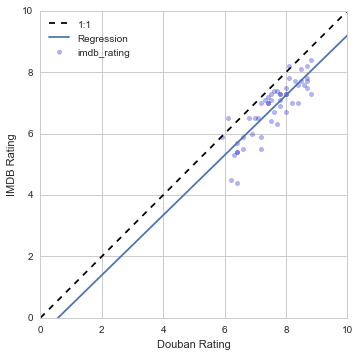

In [38]:
sub_df = df[df['genre'].str.contains('Animation')]
fig, _ , scatter_plot = plot_movie_scatter_comparison(sub_df)

In [39]:
turn_scatter_into_interactive(fig, scatter_plot, sub_df, 'animation_movies.html')

D:\Anaconda2\lib\site-packages\mpld3\mplexporter\exporter.py:171: UserWarning: Legend element <matplotlib.collections.PathCollection object at 0x00000000123F54A8> not impemented
  warnings.warn("Legend element %s not impemented" % child)
